## FIFA World Cup 2026 Prediction Model

This notebook builds a robust prediction model for the 2026 FIFA World Cup using
historic international match results and FIFA ranking data.  It implements several
improvements over simpler baselines:

* **Proper home/neutral encoding** - a separate feature captures home advantage
  only when the match is not played at a neutral venue.
* **Friendlies filtered out** - only competitive matches are used for training,
  avoiding noise from exhibition games.
* **Recency weighting** - more recent matches receive more weight so that the model
  reflects current team strength.
* **Team strength estimation** - basic attack and defence ratings are derived
  from historical goals scored and conceded.
* **Poisson regression model** - expected goals are modelled as a function of
  FIFA ranking points difference, home advantage and attack/defence features.
* **2026 World Cup simulation** - the official 48-team tournament format is
  simulated with a reproducible random number generator.

### How to use this notebook

1. Run the notebook from top to bottom (via **Run all**).
2. After the model has been fit, you can call `team_report("Team Name")` to
   view the predicted champion probability for a specific team and see how it
   compares with other contenders.
3. Use `run_tournament_sims(n_sims=1000)` to run repeated tournament simulations
   and view champion probabilities across all teams.

The code is designed to be simple and transparent for educational purposes.


In [14]:
# Imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime
from itertools import combinations
from typing import Dict, List, Tuple, Optional

# Ensure reproducibility
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)



In [15]:
# Load data from local CSV files

# Paths to the CSV files downloaded from GitHub.  If you wish to update the
# underlying data, simply overwrite these files in the same directory.
results_path = 'https://raw.githubusercontent.com/martj42/international_results/master/results.csv'
ranking_path = 'https://raw.githubusercontent.com/Dato-Futbol/fifa-ranking/master/ranking_fifa_historical.csv'

# Read the results and ranking data
df_results_raw = pd.read_csv(results_path)
df_rank_raw = pd.read_csv(ranking_path)

print(f'Results data: {df_results_raw.shape[0]} rows, {df_results_raw.shape[1]} columns')
print(f'Ranking data: {df_rank_raw.shape[0]} rows, {df_rank_raw.shape[1]} columns')


Results data: 49071 rows, 9 columns
Ranking data: 67894 rows, 6 columns


In [16]:
# Preprocessing functions

def preprocess_data(df_results: pd.DataFrame, df_rank: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, float], Dict[str, float], pd.DataFrame]:
    '''Clean and merge the results and ranking data.

    Returns
    -------
    df_long : DataFrame
        Long-format match data with features for modelling.
    attack_strengths : dict
        Mapping of team to their attack strength (relative to global average).
    defence_strengths : dict
        Mapping of team to their defence strength (relative to global average).
    latest_ranking : DataFrame
        Latest FIFA ranking table used to select World Cup teams.
    '''

    # Standardise column names
    df_results = df_results.copy()
    df_results.columns = [c.strip().lower().replace(' ', '_') for c in df_results.columns]
    df_rank = df_rank.copy()
    df_rank.columns = [c.strip().lower().replace(' ', '_') for c in df_rank.columns]

    # Parse dates in results
    df_results['date'] = pd.to_datetime(df_results['date'], errors='coerce')
    df_results = df_results.dropna(subset=['date', 'home_team', 'away_team', 'home_score', 'away_score'])

    # Filter out friendlies (they contain little predictive signal for competitive tournaments)
    if 'tournament' in df_results.columns:
        df_results = df_results[~df_results['tournament'].str.contains('Friendly', case=False, na=False)].copy()

    # Convert neutral column to int (TRUE/FALSE or true/false strings -> 1/0)
    if 'neutral' in df_results.columns:
        df_results['neutral'] = df_results['neutral'].astype(str).str.strip().str.lower().map({'true':1, 'false':0}).fillna(0).astype(int)
    else:
        df_results['neutral'] = 0

    # Build long-format data: one row per team per match
    home_df = df_results[['date', 'home_team', 'away_team', 'home_score', 'away_score', 'neutral']].copy()
    home_df.rename(columns={'home_team':'team', 'away_team':'opponent', 'home_score':'goals', 'away_score':'opponent_goals'}, inplace=True)
    home_df['home'] = 1

    away_df = df_results[['date', 'away_team', 'home_team', 'away_score', 'home_score', 'neutral']].copy()
    away_df.rename(columns={'away_team':'team', 'home_team':'opponent', 'away_score':'goals', 'home_score':'opponent_goals'}, inplace=True)
    away_df['home'] = 0

    df_long = pd.concat([home_df, away_df], ignore_index=True)

    # Merge ranking points using merge_asof.  Identify ranking date column and points column.
    # Parse ranking dates
    if 'date' in df_rank.columns:
        df_rank['date'] = pd.to_datetime(df_rank['date'], errors='coerce')
    elif 'rank_date' in df_rank.columns:
        df_rank['date'] = pd.to_datetime(df_rank['rank_date'], errors='coerce')
    else:
        raise ValueError('Cannot find ranking date column')

    # Determine points column
    points_col = None
    for cand in ['total_points', 'points', 'rating', 'previous_points']:
        if cand in df_rank.columns:
            points_col = cand
            break
    if points_col is None:
        raise ValueError(f'No points column in ranking data: {list(df_rank.columns)}')

    df_rank_small = df_rank[['date', 'team', points_col]].copy()
    df_rank_small.rename(columns={points_col:'fifa_points'}, inplace=True)
    df_rank_small['team'] = df_rank_small['team'].astype(str).str.strip()

    # Sort ranking for merge_asof
    df_rank_small = df_rank_small.sort_values(['team', 'date']).reset_index(drop=True)

    # Sort long data for merge_asof
    df_long = df_long.sort_values(['team', 'date']).reset_index(drop=True)

    # Perform merge_asof for each team separately
    # merge_asof does not support on multiple keys directly, so we group.
    merged_list = []
    for team, group in df_long.groupby('team', sort=False):
        # Sort both left and right by date for merge_asof
        rank_team = df_rank_small[df_rank_small['team'] == team]
        if not group.empty:
            group_sorted = group.sort_values('date')
            rank_sorted = rank_team.sort_values('date')
            merged = pd.merge_asof(group_sorted, rank_sorted, by='team', left_on='date', right_on='date', direction='backward')
            merged_list.append(merged)
    df_long = pd.concat(merged_list, ignore_index=True)

    # For rows without a previous ranking (old matches), fill fifa_points with overall median
    median_points = df_rank_small['fifa_points'].median()
    df_long['fifa_points'] = df_long['fifa_points'].fillna(median_points)

    # Compute opponent fifa points by merging on opponent name
    # We assume opponent names appear similarly in ranking data; if not found use median.
    opponent_rank = df_rank_small.rename(columns={'team':'opponent', 'fifa_points':'opponent_points'})
    opponent_rank = opponent_rank.sort_values(['opponent', 'date']).reset_index(drop=True)
    merged_list = []
    for opp, group in df_long.groupby('opponent', sort=False):
        # Ensure both left and right frames are sorted by date for merge_asof
        rank_opp = opponent_rank[opponent_rank['opponent'] == opp]
        if not group.empty:
            group_sorted = group.sort_values('date')
            rank_sorted = rank_opp.sort_values('date')
            merged = pd.merge_asof(group_sorted, rank_sorted, by='opponent', left_on='date', right_on='date', direction='backward')
            merged_list.append(merged)
    df_long = pd.concat(merged_list, ignore_index=True)
    df_long['opponent_points'] = df_long['opponent_points'].fillna(median_points)

    # Points difference
    df_long['points_diff'] = df_long['fifa_points'] - df_long['opponent_points']

    # Compute home advantage only when not neutral
    df_long['home_adv'] = df_long['home'] * (1 - df_long['neutral'])

    # Compute basic team attack/defence strengths from raw results
    # Aggregated over all competitive matches (friendlies removed).
    # Compute total goals scored and conceded per team
    goals_for = (df_results[['home_team','home_score']]
                            .rename(columns={'home_team':'team','home_score':'goals'})
                 .groupby('team')['goals'].sum())
    goals_for += (df_results[['away_team','away_score']]
                            .rename(columns={'away_team':'team','away_score':'goals'})
                 .groupby('team')['goals'].sum())
    goals_for = goals_for.groupby(level=0).sum()

    goals_against = (df_results[['home_team','away_score']]
                               .rename(columns={'home_team':'team','away_score':'goals'})
                      .groupby('team')['goals'].sum())
    goals_against += (df_results[['away_team','home_score']]
                               .rename(columns={'away_team':'team','home_score':'goals'})
                      .groupby('team')['goals'].sum())
    goals_against = goals_against.groupby(level=0).sum()

    matches_played = (df_results['home_team'].value_counts() + df_results['away_team'].value_counts()).groupby(level=0).sum()
    avg_goals_for = goals_for / matches_played
    avg_goals_against = goals_against / matches_played

    global_avg_for = goals_for.sum() / matches_played.sum()
    global_avg_against = goals_against.sum() / matches_played.sum()

    attack_strengths = (avg_goals_for / global_avg_for).to_dict()
    defence_strengths = (avg_goals_against / global_avg_against).to_dict()

    # Add attack advantage feature: log ratio of team attack to opponent defence
    def compute_attack_adv(row):
        a = attack_strengths.get(row['team'], 1.0)
        d = defence_strengths.get(row['opponent'], 1.0)
        return np.log((a + 1e-8) / (d + 1e-8))

    df_long['attack_advantage'] = df_long.apply(compute_attack_adv, axis=1)

    # Restrict to matches on or before the latest ranking date to avoid
    # looking into the future when merging rankings and computing recency.
    latest_date = df_rank_small['date'].max()
    df_long = df_long[df_long['date'] <= latest_date].copy()
    # Recency weight: more recent matches have more weight.  Use a simple reciprocal
    # function of years since the match.
    years_since = (latest_date - df_long['date']).dt.days / 365.25
    # Replace negative values (should not occur) and missing with zero
    years_since = years_since.clip(lower=0).fillna(0)
    df_long['weight'] = 1.0 / (1.0 + years_since)

    # Prepare latest ranking table for selecting teams (top 48)
    latest_ranking = df_rank_small[df_rank_small['date'] == latest_date].copy()
    latest_ranking = latest_ranking.sort_values('fifa_points', ascending=False).reset_index(drop=True)

    return df_long, attack_strengths, defence_strengths, latest_ranking



In [17]:
# Prepare data and fit the Poisson regression model

df_long, attack_strengths, defence_strengths, latest_ranking = preprocess_data(df_results_raw, df_rank_raw)

print(f'Long data shape after preprocessing: {df_long.shape}')

# Fit Poisson regression for the mean model (initial fit)
formula = 'goals ~ points_diff + home_adv + attack_advantage + neutral'
model = smf.glm(formula=formula,
               data=df_long,
               family=sm.families.Poisson(),
               freq_weights=df_long['weight']).fit()
print('Initial Poisson GLM fit (used to estimate dispersion):')
print(model.summary())

# Basic overdispersion check: Pearson chi^2 / df
pearson_chi2 = ((model.resid_pearson**2).sum())
dof = df_long.shape[0] - model.df_model - 1
overdisp = pearson_chi2 / dof
print(f'Overdispersion ratio (should be near 1.0 for Poisson): {overdisp:.2f}')

# Estimate Negative Binomial dispersion (alpha) via method-of-moments:
mu_hat = model.predict(df_long)
sse = ((df_long['goals'] - mu_hat) ** 2).sum()
num = sse - mu_hat.sum()
den = (mu_hat ** 2).sum()
alpha_nb = max(0.0, num / den) if den > 0 else 0.0
print(f'Estimated Negative Binomial alpha (method-of-moments): {alpha_nb:.6f}')

# If alpha indicates overdispersion, attempt to fit a Negative Binomial GLM (NB2 / Gamma-Poisson)
if alpha_nb > 1e-8:
    print('Attempting to fit Negative Binomial GLM using estimated alpha (NB2 parameterization)...')
    try:
        nb_family = sm.families.NegativeBinomial(alpha=alpha_nb)
        nb_model = smf.glm(formula=formula,
                          data=df_long,
                          family=nb_family,
                          freq_weights=df_long['weight']).fit()
        print('Negative Binomial GLM fit successful:')
        print(nb_model.summary())
        # Replace the model used for prediction with the NB fit
        model = nb_model
        # Store the alpha used/estimated
        alpha_nb = float(alpha_nb)
        print(f'Using Negative Binomial GLM with alpha={alpha_nb:.6f} for simulation draws.')
    except Exception as e:
        print('Negative Binomial GLM fit failed, will continue using Poisson fit for mean model. Error:', e)
else:
    print('Alpha near zero; Poisson draws are likely adequate for simulation.')

# Prepare a lookup for FIFA points
latest_points = latest_ranking.set_index('team')['fifa_points'].to_dict()
median_points = np.median(list(latest_points.values()))

Long data shape after preprocessing: (59412, 13)
Initial Poisson GLM fit (used to estimate dispersion):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                59310
Model:                            GLM   Df Residuals:                  5212.86
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8320.8
Date:                Tue, 17 Feb 2026   Deviance:                       7888.5
Time:                        17:26:15   Pearson chi2:                 8.10e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01396
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------

Dispersion (Pearson Chi^2 / df_resid): 11.124


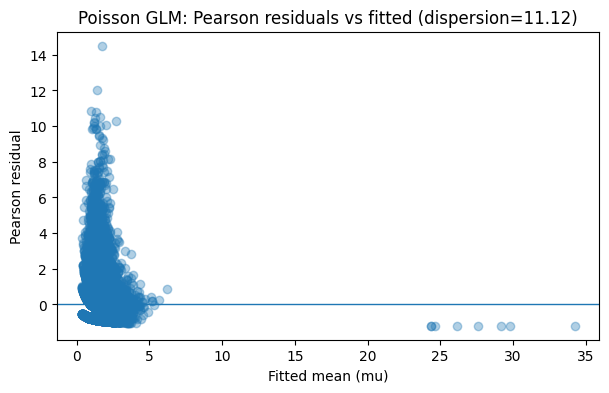

In [18]:
# Uses your fitted Poisson GLM: `model`
mu = model.fittedvalues                 # E[y|x]
rP = model.resid_pearson                # Pearson residuals

dispersion = np.sum(rP**2) / model.df_resid
print(f"Dispersion (Pearson Chi^2 / df_resid): {dispersion:.3f}")

plt.figure(figsize=(7,4))
plt.scatter(mu, rP, alpha=0.35)
plt.axhline(0, linewidth=1)
plt.xlabel("Fitted mean (mu)")
plt.ylabel("Pearson residual")
plt.title(f"Poisson GLM: Pearson residuals vs fitted (dispersion={dispersion:.2f})")
plt.show()


In [19]:
# Prediction and simulation functions

def expected_goals(team: str, opponent: str, is_home: bool, neutral: bool) -> float:
    # Compute the expected goals for a team against an opponent using the fitted model.
    # Determine FIFA points difference
    team_pts = latest_points.get(team, median_points)
    opp_pts = latest_points.get(opponent, median_points)
    points_diff = team_pts - opp_pts
    # Home advantage flag
    home_adv = 1 if (is_home and not neutral) else 0
    # Neutral indicator
    neutral_int = 1 if neutral else 0
    # Attack advantage feature
    atk = attack_strengths.get(team, 1.0)
    defn = defence_strengths.get(opponent, 1.0)
    attack_advantage = np.log((atk + 1e-8) / (defn + 1e-8))
    # Build a single-row DataFrame for prediction
    X_pred = pd.DataFrame({
        'points_diff': [points_diff],
        'home_adv': [home_adv],
        'attack_advantage': [attack_advantage],
        'neutral': [neutral_int]
    })
    # Predict expected goals
    lambda_hat = model.predict(X_pred).iloc[0]
    return float(lambda_hat)


def simulate_match(team_a: str, team_b: str, neutral: bool = False) -> Tuple[int, int]:
    # Simulate a single match using Negative Binomial (Gamma-Poisson) draws when dispersion is present.
    goals_a_exp = expected_goals(team_a, team_b, is_home=True, neutral=neutral)
    goals_b_exp = expected_goals(team_b, team_a, is_home=False, neutral=neutral)
    alpha = globals().get('alpha_nb', 0.0)

    def _draw_goals(mu: float) -> int:
        if mu <= 0:
            return 0
        # If alpha > 0, use a Gamma-Poisson mixture to introduce overdispersion
        if alpha > 1e-8:
            k = 1.0 / alpha
            theta = alpha * mu
            lam = rng.gamma(shape=k, scale=theta)
            return int(rng.poisson(lam))
        else:
            return int(rng.poisson(mu))

    goals_a = _draw_goals(goals_a_exp)
    goals_b = _draw_goals(goals_b_exp)
    return goals_a, goals_b


def simulate_group(teams: List[str]) -> pd.DataFrame:
    # Simulate all matches within a group of four teams and return a standings table.
    standings = {team: {'points': 0, 'gf': 0, 'ga': 0} for team in teams}
    for i in range(len(teams)):
        for j in range(i+1, len(teams)):
            team_a, team_b = teams[i], teams[j]
            gf_a, gf_b = simulate_match(team_a, team_b, neutral=True)
            standings[team_a]['gf'] += gf_a
            standings[team_a]['ga'] += gf_b
            standings[team_b]['gf'] += gf_b
            standings[team_b]['ga'] += gf_a
            if gf_a > gf_b:
                standings[team_a]['points'] += 3
            elif gf_b > gf_a:
                standings[team_b]['points'] += 3
            else:
                standings[team_a]['points'] += 1
                standings[team_b]['points'] += 1
    # Convert to DataFrame and sort
    df = pd.DataFrame([
        {
            'team': team,
            'points': vals['points'],
            'goal_diff': vals['gf'] - vals['ga'],
            'goals_for': vals['gf']
        }
        for team, vals in standings.items()
    ])
    df = df.sort_values(['points', 'goal_diff', 'goals_for'], ascending=[False, False, False]).reset_index(drop=True)
    return df


def simulate_knockout_round(teams: List[str]) -> List[str]:
    # Given a list of teams, pair them and simulate a knockout round.
    winners = []
    for i in range(0, len(teams), 2):
        team_a, team_b = teams[i], teams[i+1]
        while True:
            gf_a, gf_b = simulate_match(team_a, team_b, neutral=True)
            if gf_a > gf_b:
                winners.append(team_a)
                break
            elif gf_b > gf_a:
                winners.append(team_b)
                break
            # If draw, repeat until there is a winner
    return winners


def simulate_tournament_once(team_list: List[str]) -> str:
    # Simulate one complete World Cup tournament and return the champion.
    teams = list(team_list)
    rng.shuffle(teams)
    groups = [teams[i*4:(i+1)*4] for i in range(12)]
    qualifiers: List[str] = []
    third_place_candidates: List[pd.Series] = []
    for grp in groups:
        standings = simulate_group(grp)
        qualifiers.extend(standings['team'].iloc[:2].tolist())
        third_place_candidates.append(standings.iloc[2])
    # Rank third-placed teams
    third_df = pd.DataFrame(third_place_candidates)
    third_df = third_df.sort_values(['points','goal_diff','goals_for'], ascending=[False, False, False]).reset_index(drop=True)
    qualifiers.extend(third_df['team'].iloc[:8].tolist())
    rng.shuffle(qualifiers)
    current_round = qualifiers
    while len(current_round) > 1:
        current_round = simulate_knockout_round(current_round)
    return current_round[0]


from joblib import Parallel, delayed
import multiprocessing


def _sim_batch(seed_start: int, batch_size: int, top_48_local: List[str]) -> List[str]:
    """Simulate `batch_size` tournaments in one worker using a local RNG.

    This reduces inter-process overhead by performing multiple simulations per task
    and ensures reproducibility by seeding the local RNG deterministically.
    """
    rng_local = np.random.default_rng(seed_start)
    winners: List[str] = []
    # Temporarily assign the module-level rng to the local RNG so existing
    # simulate_* functions (which reference `rng`) work unchanged.
    global rng
    rng = rng_local
    for _ in range(batch_size):
        winners.append(simulate_tournament_once(top_48_local))
    return winners


def run_tournament_sims(n_sims: int = 1000, n_jobs: int = -1, batch_size: Optional[int] = None) -> pd.DataFrame:
    """Run multiple tournament simulations (parallelized, batched) and return champion probabilities.

    Parameters
    ----------
    n_sims : int
        Total number of tournament simulations to run.
    n_jobs : int
        Number of parallel worker processes to use (use -1 to use all CPUs).
    batch_size : Optional[int]
        Number of simulations to run per worker task. If None, it is chosen
        automatically based on n_sims and number of workers to balance
        overhead and parallelism.
    """
    top_48 = latest_ranking['team'].iloc[:48].tolist()

    # Determine number of workers
    cpu_count = multiprocessing.cpu_count()
    n_workers = cpu_count if n_jobs == -1 else max(1, n_jobs)

    # Choose a reasonable batch size if not provided
    if batch_size is None:
        batch_size = max(1, n_sims // (n_workers * 4))

    # Build list of (seed, batch) tuples
    batches = []
    seeds = []
    remaining = n_sims
    seed_counter = 0
    while remaining > 0:
        b = min(batch_size, remaining)
        batches.append(b)
        seeds.append(RANDOM_SEED + seed_counter)
        remaining -= b
        seed_counter += b

    # Run batches in parallel
    results = Parallel(n_jobs=n_workers)(
        delayed(_sim_batch)(seed, b, top_48) for seed, b in zip(seeds, batches)
    )

    # Flatten winners and count
    winners = [w for batch in results for w in batch]
    counts: Dict[str, int] = {team: 0 for team in top_48}
    for w in winners:
        counts[w] += 1

    prob_df = pd.DataFrame({
        'team': list(counts.keys()),
        'champion_prob': [counts[t] / n_sims for t in counts]
    })
    prob_df = prob_df.sort_values('champion_prob', ascending=False).reset_index(drop=True)
    return prob_df


def team_report(team_name: str, n_sims: int = 1000, n_jobs: int = -1, batch_size: Optional[int] = None):
    # Print the champion probability for a specified team and show the top contenders.
    team_name = team_name.strip()
    if not team_name:
        print("Please provide a non-empty team name.")
        return
    if n_sims > 2000:
        print("Warning: large n_sims may take a long time. Consider lowering n_sims or using the ML-based team_report_ml for speed.")

    prob_df = run_tournament_sims(n_sims=n_sims, n_jobs=n_jobs, batch_size=batch_size)

    # Show the top ten teams by champion probability
    print(prob_df.head(10))

    # Find the requested team and report its probability (if present)
    mask = prob_df['team'].str.lower() == team_name.lower()
    print()
    if mask.any():
        prob = prob_df.loc[mask, 'champion_prob'].iloc[0]
        print(f"Predicted probability of {team_name} winning the World Cup: {prob:.2%}")
    else:
        print(f"Team '{team_name}' not found among the top 48 teams by FIFA points.")

    # Print a blank line before the report for readability
    print()

In [20]:
# Reset RNG so simulation results are repeatable each run
rng = np.random.default_rng(RANDOM_SEED)


In [21]:
# How many tournament simulations to run (reduced for quicker feedback; increase for smoother probabilities)
N_SIMS = 100  # lower default for interactive development

import multiprocessing
batch_size = max(1, N_SIMS // max(1, multiprocessing.cpu_count()))
print(f"Running {N_SIMS} simulations using {multiprocessing.cpu_count()} cores with batch_size={batch_size}...")
start_time = datetime.now()
prob_df = run_tournament_sims(n_sims=N_SIMS, n_jobs=-1, batch_size=batch_size)
elapsed = (datetime.now() - start_time).total_seconds()
print(f"Completed {N_SIMS} simulations in {elapsed:.2f}s")

print("Top 5 most likely champions (by simulation probability):")
display(prob_df.head(5))

predicted_winner = prob_df.iloc[0]["team"]
predicted_winner_prob = prob_df.iloc[0]["champion_prob"]

print()
print(f"Predicted winner (most likely): {predicted_winner}  |  Probability: {predicted_winner_prob:.2%}")


Running 100 simulations using 2 cores with batch_size=50...
Completed 100 simulations in 114.15s
Top 5 most likely champions (by simulation probability):


,team,champion_prob
0,Argentina,0.10
1,Brazil,0.08
2,Uruguay,0.08
3,Netherlands,0.06
4,France,0.06



Predicted winner (most likely): Argentina  |  Probability: 10.00%


In [22]:
# One example tournament run (one possible outcome)
top_48_teams = latest_ranking["team"].iloc[:48].tolist()

rng = np.random.default_rng(RANDOM_SEED)  # reset again if you want this to be reproducible
one_champion = simulate_tournament_once(top_48_teams)

print(f"Champion from ONE simulated tournament run: {one_champion}")


Champion from ONE simulated tournament run: Nigeria


In [23]:
# Example: team report
rng = np.random.default_rng(RANDOM_SEED)  # reset so this is reproducible too
# Use fewer sims for quick interactive feedback. Increase n_sims for more stable estimates.
team_report("Argentina", n_sims=100, n_jobs=-1)     # change the team name and n_sims as needed


          team  champion_prob
0      England           0.08
1      Uruguay           0.08
2        Italy           0.06
3        Spain           0.06
4      Croatia           0.05
5     Colombia           0.05
6       France           0.05
7    Argentina           0.04
8  Switzerland           0.04
9  Netherlands           0.04

Predicted probability of Argentina winning the World Cup: 4.00%



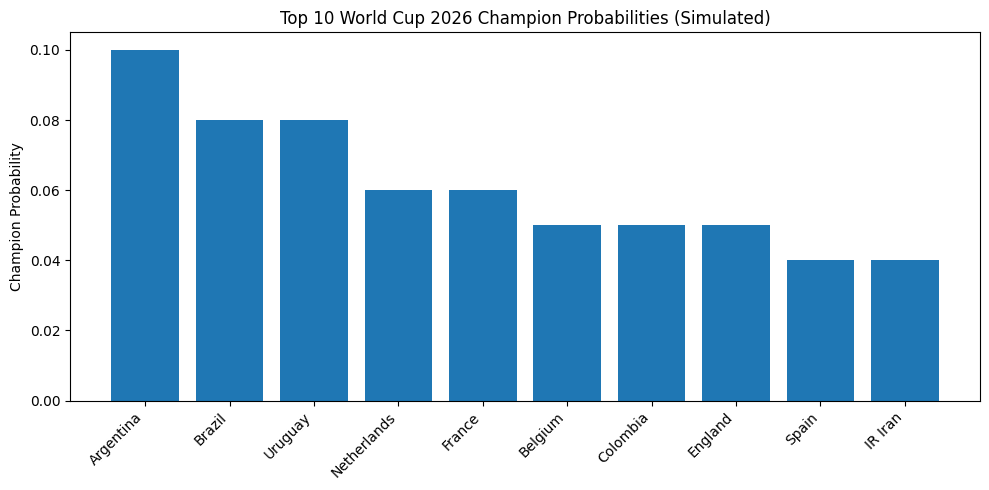

In [24]:
import matplotlib.pyplot as plt

top10 = prob_df.head(10).copy()
plt.figure(figsize=(10, 5))
plt.bar(top10["team"], top10["champion_prob"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Champion Probability")
plt.title("Top 10 World Cup 2026 Champion Probabilities (Simulated)")
plt.tight_layout()
plt.show()


## Machine‑Learning Outcome Model

The following cells implement a machine‑learning approach to estimate match outcomes (win/draw/loss) using a combination of a RandomForest and a gradient boosting classifier. These models predict probabilities directly from the same features used in the Poisson regression (ranking points difference, home advantage, attack vs defence advantage and neutral indicator). We then use these probabilities to simulate tournaments and estimate champion probabilities.

In [25]:
# Build a training dataset for match outcomes (home perspective)
# We use the long-format data to extract only the home team rows and assign an outcome label:
#   2 for a home win, 1 for a draw, 0 for a home loss.

clf_df = df_long[df_long['home'] == 1].copy()
clf_df['outcome'] = np.where(clf_df['goals'] > clf_df['opponent_goals'], 2,
                             np.where(clf_df['goals'] == clf_df['opponent_goals'], 1, 0))

X_clf = clf_df[['points_diff', 'home_adv', 'attack_advantage', 'neutral']]
y_clf = clf_df['outcome']
weights_clf = clf_df['weight']

# Split the data into training and test sets for a simple evaluation.  A stratified split
# is used so that each outcome class is represented proportionally in both sets.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X_clf, y_clf, weights_clf, test_size=0.2, random_state=RANDOM_SEED, stratify=y_clf
)

# Train a RandomForest and a HistGradientBoosting classifier using sample weights.
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

# RandomForest with balanced class weights to mitigate class imbalance
rf_clf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=RANDOM_SEED
)
rf_clf.fit(X_train, y_train, sample_weight=w_train)

# HistGradientBoosting; depth constrained for simplicity
gb_clf = HistGradientBoostingClassifier(max_depth=4, random_state=RANDOM_SEED)
gb_clf.fit(X_train, y_train, sample_weight=w_train)

# Evaluate both models on the held‑out set
rf_pred = rf_clf.predict(X_test)
gb_pred = gb_clf.predict(X_test)
rf_acc = (rf_pred == y_test).mean()
gb_acc = (gb_pred == y_test).mean()
print(f"RandomForest accuracy: {rf_acc:.3f}")
print(f"GradientBoosting accuracy: {gb_acc:.3f}")

# We will use an ensemble of these two models by averaging their predicted probabilities.

def predict_match_outcome_prob(team_a: str, team_b: str, neutral: bool) -> np.ndarray:
    """Predict probabilities of [loss, draw, win] from the home team's perspective using the ensemble."""
    # Compute features from the home team's perspective
    team_pts = latest_points.get(team_a, median_points)
    opp_pts = latest_points.get(team_b, median_points)
    points_diff = team_pts - opp_pts
    home_adv = 0 if neutral else 1  # home advantage applies only when not neutral
    neutral_int = 1 if neutral else 0
    atk = attack_strengths.get(team_a, 1.0)
    defn = defence_strengths.get(team_b, 1.0)
    attack_advantage = np.log((atk + 1e-8) / (defn + 1e-8))
    X_pred = pd.DataFrame({
        'points_diff': [points_diff],
        'home_adv': [home_adv],
        'attack_advantage': [attack_advantage],
        'neutral': [neutral_int]
    })
    # Get probability vectors from both models
    rf_probs = rf_clf.predict_proba(X_pred)[0]
    gb_probs = gb_clf.predict_proba(X_pred)[0]
    # Align probabilities so that the order is [loss, draw, win].  scikit‑learn returns
    # probabilities in the order of rf_clf.classes_.  We reorder accordingly.
    def reorder(probs, classes):
        order = [list(classes).index(cls) for cls in [0, 1, 2]]
        return probs[order]
    rf_reord = reorder(rf_probs, rf_clf.classes_)
    gb_reord = reorder(gb_probs, gb_clf.classes_)
    return (rf_reord + gb_reord) / 2.0

def simulate_match_ml(team_a: str, team_b: str, neutral: bool = False) -> Tuple[int, int]:
    """Simulate a single match between two teams using the ML outcome model.

    Returns a tuple of goals for team_a and team_b.  Goals are simplified:
    1-0 for a win, 0-1 for a loss, 1-1 for a draw.
    """
    probs_home = predict_match_outcome_prob(team_a, team_b, neutral)
    outcome_home = rng.choice([0, 1, 2], p=probs_home)
    if outcome_home == 2:
        gf_a, gf_b = 1, 0  # home win
    elif outcome_home == 0:
        gf_a, gf_b = 0, 1  # home loss
    else:
        gf_a, gf_b = 1, 1  # draw
    return gf_a, gf_b

def simulate_group_ml(teams: List[str]) -> pd.DataFrame:
    """Simulate all matches within a group using the ML model and return a standings table."""
    standings = {team: {'points': 0, 'gf': 0, 'ga': 0} for team in teams}
    for i in range(len(teams)):
        for j in range(i+1, len(teams)):
            team_a, team_b = teams[i], teams[j]
            gf_a, gf_b = simulate_match_ml(team_a, team_b, neutral=True)
            standings[team_a]['gf'] += gf_a
            standings[team_a]['ga'] += gf_b
            standings[team_b]['gf'] += gf_b
            standings[team_b]['ga'] += gf_a
            if gf_a > gf_b:
                standings[team_a]['points'] += 3
            elif gf_b > gf_a:
                standings[team_b]['points'] += 3
            else:
                standings[team_a]['points'] += 1
                standings[team_b]['points'] += 1
    df = pd.DataFrame([
        {
            'team': team,
            'points': vals['points'],
            'goal_diff': vals['gf'] - vals['ga'],
            'goals_for': vals['gf']
        }
        for team, vals in standings.items()
    ])
    df = df.sort_values(['points', 'goal_diff', 'goals_for'], ascending=[False, False, False]).reset_index(drop=True)
    return df

def simulate_knockout_round_ml(teams: List[str]) -> List[str]:
    """Simulate a knockout round using the ML model, returning the list of winners."""
    winners = []
    for i in range(0, len(teams), 2):
        team_a, team_b = teams[i], teams[i+1]
        while True:
            gf_a, gf_b = simulate_match_ml(team_a, team_b, neutral=True)
            if gf_a > gf_b:
                winners.append(team_a)
                break
            elif gf_b > gf_a:
                winners.append(team_b)
                break
            # If draw, repeat until there is a winner
    return winners

def simulate_tournament_once_ml(team_list: List[str]) -> str:
    """Simulate one complete World Cup tournament using the ML model and return the champion."""
    teams = list(team_list)
    rng.shuffle(teams)
    groups = [teams[i*4:(i+1)*4] for i in range(12)]
    qualifiers = []
    third_place_candidates = []
    for grp in groups:
        standings = simulate_group_ml(grp)
        qualifiers.extend(standings['team'].iloc[:2].tolist())
        third_place_candidates.append(standings.iloc[2])
    # Rank third-placed teams
    third_df = pd.DataFrame(third_place_candidates)
    third_df = third_df.sort_values(['points','goal_diff','goals_for'], ascending=[False, False, False]).reset_index(drop=True)
    qualifiers.extend(third_df['team'].iloc[:8].tolist())
    rng.shuffle(qualifiers)
    current_round = qualifiers
    while len(current_round) > 1:
        current_round = simulate_knockout_round_ml(current_round)
    return current_round[0]

def _sim_batch_ml(seed_start: int, batch_size: int, top_48_local: List[str]) -> List[str]:
    """Simulate `batch_size` tournaments in one worker using a local RNG for the ML model."""
    rng_local = np.random.default_rng(seed_start)
    winners: List[str] = []
    global rng
    rng = rng_local
    for _ in range(batch_size):
        winners.append(simulate_tournament_once_ml(top_48_local))
    return winners


def run_tournament_sims_ml(n_sims: int = 1000, n_jobs: int = -1, batch_size: Optional[int] = None) -> pd.DataFrame:
    """Run multiple tournament simulations (parallelized, batched) using the ML model and return champion probabilities.

    Parameters
    ----------
    n_sims : int
        Total number of tournament simulations to run.
    n_jobs : int
        Number of parallel worker processes to use (use -1 to use all CPUs).
    batch_size : Optional[int]
        Number of simulations to run per worker task. If None, chosen automatically.
    """
    top_48 = latest_ranking['team'].iloc[:48].tolist()

    cpu_count = multiprocessing.cpu_count()
    n_workers = cpu_count if n_jobs == -1 else max(1, n_jobs)

    if batch_size is None:
        batch_size = max(1, n_sims // (n_workers * 4))

    batches = []
    seeds = []
    remaining = n_sims
    seed_counter = 0
    while remaining > 0:
        b = min(batch_size, remaining)
        batches.append(b)
        seeds.append(RANDOM_SEED + seed_counter)
        remaining -= b
        seed_counter += b

    results = Parallel(n_jobs=n_workers)(
        delayed(_sim_batch_ml)(seed, b, top_48) for seed, b in zip(seeds, batches)
    )

    winners = [w for batch in results for w in batch]
    counts = {team: 0 for team in top_48}
    for w in winners:
        counts[w] += 1

    prob_df = pd.DataFrame({
        'team': list(counts.keys()),
        'champion_prob': [counts[t] / n_sims for t in counts]
    })
    prob_df = prob_df.sort_values('champion_prob', ascending=False).reset_index(drop=True)
    return prob_df


def team_report_ml(team_name: str, n_sims: int = 1000, n_jobs: int = -1, batch_size: Optional[int] = None):
    """Print the champion probability for a specified team using the ML model and list top contenders."""
    team_name = team_name.strip()
    if not team_name:
        print("Please provide a non-empty team name.")
        return
    if n_sims > 2000:
        print("Warning: large n_sims may take a long time. Consider lowering n_sims for quick feedback.")
    prob_df = run_tournament_sims_ml(n_sims=n_sims, n_jobs=n_jobs, batch_size=batch_size)
    # Show the top ten teams by champion probability
    print(prob_df.head(10))
    mask = prob_df['team'].str.lower() == team_name.lower()
    if mask.any():
        prob = prob_df.loc[mask, 'champion_prob'].iloc[0]
        print()
        print(f"Predicted probability of {team_name} winning the World Cup (ML model): {prob:.2%}")
    else:
        print()
        print(f"Team '{team_name}' not found among the top 48 teams by FIFA points.")


RandomForest accuracy: 0.490
GradientBoosting accuracy: 0.542


In [26]:
# Reset RNG so ML simulation results are repeatable each run
rng = np.random.default_rng(RANDOM_SEED)

# How many tournament simulations to run (increase for smoother probabilities)
N_SIMS_ML = 100

import multiprocessing
batch_size_ml = max(1, N_SIMS_ML // max(1, multiprocessing.cpu_count()))
print(f"Running {N_SIMS_ML} ML sims using {multiprocessing.cpu_count()} cores with batch_size={batch_size_ml}...")
start_time = datetime.now()
prob_ml_df = run_tournament_sims_ml(n_sims=N_SIMS_ML, n_jobs=-1, batch_size=batch_size_ml)
elapsed_ml = (datetime.now() - start_time).total_seconds()
print(f"Completed {N_SIMS_ML} ML simulations in {elapsed_ml:.2f}s")

print("Top 5 most likely champions (ML model, by simulation probability):")
display(prob_ml_df.head(5))

predicted_winner_ml = prob_ml_df.iloc[0]["team"]
predicted_winner_prob_ml = prob_ml_df.iloc[0]["champion_prob"]

print()
print(f"Predicted winner (ML model): {predicted_winner_ml}  |  Probability: {predicted_winner_prob_ml:.2%}")


Running 100 ML sims using 2 cores with batch_size=50...
Completed 100 ML simulations in 213.66s
Top 5 most likely champions (ML model, by simulation probability):


,team,champion_prob
0,Argentina,0.28
1,Brazil,0.12
2,England,0.07
3,Spain,0.07
4,Belgium,0.07



Predicted winner (ML model): Argentina  |  Probability: 28.00%


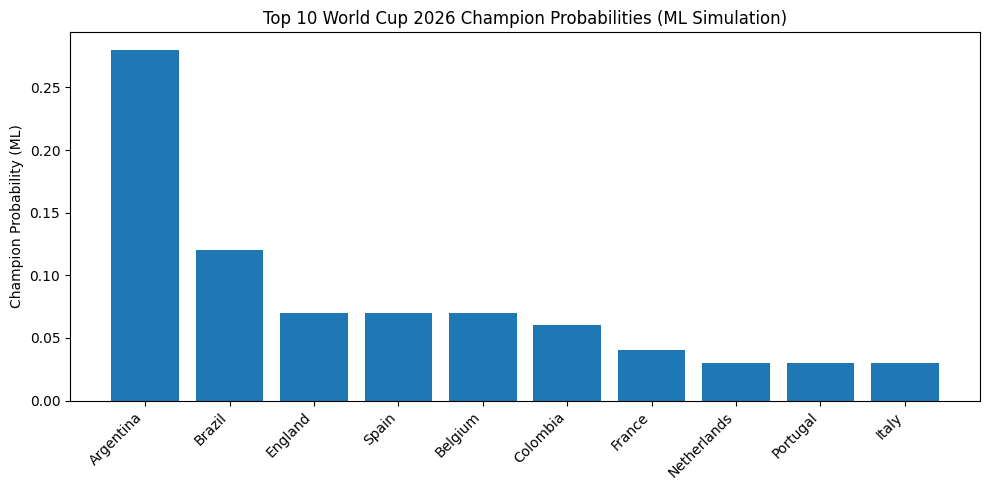

In [27]:
# Visualize the top 10 champion probabilities under the ML model
import matplotlib.pyplot as plt

top10_ml = prob_ml_df.head(10).copy()
plt.figure(figsize=(10, 5))
plt.bar(top10_ml["team"], top10_ml["champion_prob"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Champion Probability (ML)")
plt.title("Top 10 World Cup 2026 Champion Probabilities (ML Simulation)")
plt.tight_layout()
plt.show()



## Model Tuning, Calibration and Evaluation

In this section we perform a cross‑validated grid search over hyperparameters for the
RandomForest and HistGradientBoosting classifiers, calibrate the best models using a
sigmoid link function, evaluate performance metrics (accuracy, log‑loss, Brier score,
macro F1) on a held‑out test set, produce diagnostic plots (confusion matrices,
learning curves, calibration curves, feature importance) and run tournament
simulations using the calibrated ensemble with confidence intervals.


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best RF params: {'random_state': 42, 'n_estimators': 200, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': None}
Best RF CV log-loss: 1.0428369213518487
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=30. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best GB params: {'random_state': 42, 'max_iter': 100, 'max_depth': 4, 'learning_rate': 0.05}
Best GB CV log-loss: 1.0527448968446003
RF metrics: {'accuracy': 0.4806462470548637, 'log_loss': 1.0441848692369808, 'brier_score': np.float64(0.6226787316021599), 'macro_f1': 0.4371806306174451}
GB metrics: {'accuracy': 0.41905082463816895, 'log_loss': 1.0536150498941654, 'brier_score': np.float64(0.6330480922472902), 'macro_f1': 0.41375944985545204}
Ensemble metrics: {'accuracy': 0.4771120834735779, 'log_loss': 1.0254325466610714, 'brier_score': np.float64(0.6142481156411839), 'macro_f1': 0.44132281686104213}


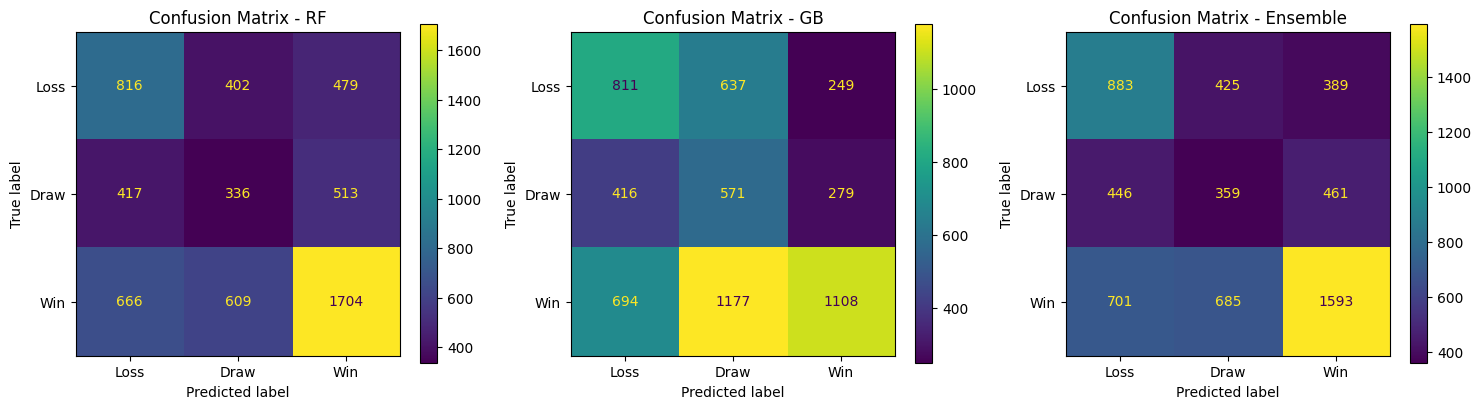

In [28]:
# Hyperparameter tuning and cross‑validation for match outcome modelling
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.inspection import permutation_importance
from sklearn.utils import class_weight
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Toggle FAST_MODE for quick interactive runs (set to False for full grid searches)
FAST_MODE = True

# Build classification dataset (home-team perspective)
clf_df = df_long[df_long['home'] == 1].copy()
clf_df['outcome'] = np.where(clf_df['goals'] > clf_df['opponent_goals'], 2,
                             np.where(clf_df['goals'] == clf_df['opponent_goals'], 1, 0))
X_clf = clf_df[['points_diff', 'home_adv', 'attack_advantage', 'neutral']]
y_clf = clf_df['outcome']
weights_clf = clf_df['weight']

# Split into train and test sets
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X_clf, y_clf, weights_clf, test_size=0.2, random_state=RANDOM_SEED, stratify=y_clf
)

# Compute class weights and adjust training sample weights
classes = np.array([0, 1, 2])
cw = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_map = {c: w for c, w in zip(classes, cw)}
# Adjust training weights: recency weight multiplied by class weight
w_train_adj = w_train * np.array([class_weight_map[cls] for cls in y_train])

# Define (smaller) parameter spaces for FAST_MODE, and larger grids for full runs
if FAST_MODE:
    rf_param_space = {
        "n_estimators": [100, 200],
        "max_depth": [4, 6, None],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", 0.5],
        "random_state": [RANDOM_SEED],
    }
    gb_param_space = {
        "learning_rate": [0.05, 0.1],
        "max_iter": [100, 300],
        "max_depth": [2, 4],
        "random_state": [RANDOM_SEED],
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    n_iter_search = 30
    verbose_level = 1
else:
    rf_param_space = {
        "n_estimators": [300, 600, 900],
        "max_depth": [6, 8, 12, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4, 6],
        "max_features": ["sqrt", 0.5, 1.0],
        "class_weight": ["balanced", "balanced_subsample"],
        "bootstrap": [True],
        "max_samples": [0.7, 1.0],
        "random_state": [RANDOM_SEED],
    }
    gb_param_space = {
        "learning_rate": [0.03, 0.05, 0.1],
        "max_iter": [300, 600, 1000],
        "max_depth": [2, 4, 6, 8],
        "min_samples_leaf": [10, 20, 50, 100],
        "l2_regularization": [0.0, 0.1, 1.0, 5.0],
        "max_leaf_nodes": [15, 31, 63],
        "random_state": [RANDOM_SEED],
    }
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
    n_iter_search = None
    verbose_level = 2

# Search for RandomForest
if FAST_MODE:
    rf_search = RandomizedSearchCV(
        estimator=RandomForestClassifier(),
        param_distributions=rf_param_space,
        n_iter=n_iter_search,
        scoring='neg_log_loss',
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=verbose_level,
        random_state=RANDOM_SEED,
    )
else:
    rf_search = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid=rf_param_space,
        scoring='neg_log_loss',
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=verbose_level,
    )

rf_search.fit(X_train, y_train, sample_weight=w_train_adj)
best_rf = rf_search.best_estimator_
print('Best RF params:', rf_search.best_params_)
print('Best RF CV log-loss:', -rf_search.best_score_)

# Search for HistGradientBoosting
if FAST_MODE:
    gb_search = RandomizedSearchCV(
        estimator=HistGradientBoostingClassifier(),
        param_distributions=gb_param_space,
        n_iter=n_iter_search,
        scoring='neg_log_loss',
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=verbose_level,
        random_state=RANDOM_SEED,
    )
else:
    gb_search = GridSearchCV(
        estimator=HistGradientBoostingClassifier(),
        param_grid=gb_param_space,
        scoring='neg_log_loss',
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=verbose_level,
    )

gb_search.fit(X_train, y_train, sample_weight=w_train_adj)
best_gb = gb_search.best_estimator_
print('Best GB params:', gb_search.best_params_)
print('Best GB CV log-loss:', -gb_search.best_score_)

# Evaluate models on the test set
rf_probs_test = best_rf.predict_proba(X_test)
rf_preds_test = rf_probs_test.argmax(axis=1)
gb_probs_test = best_gb.predict_proba(X_test)
gb_preds_test = gb_probs_test.argmax(axis=1)
ens_probs_test = (rf_probs_test + gb_probs_test) / 2.0
ens_preds_test = ens_probs_test.argmax(axis=1)

# Metric computation helper
def compute_metrics(y_true, y_pred, y_proba):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['log_loss'] = log_loss(y_true, y_proba, labels=[0,1,2])
    y_true_oh = np.eye(3)[y_true]
    metrics['brier_score'] = np.mean(np.sum((y_proba - y_true_oh)**2, axis=1))
    metrics['macro_f1'] = f1_score(y_true, y_pred, average='macro')
    return metrics

rf_metrics = compute_metrics(y_test, rf_preds_test, rf_probs_test)
gb_metrics = compute_metrics(y_test, gb_preds_test, gb_probs_test)
ens_metrics = compute_metrics(y_test, ens_preds_test, ens_probs_test)
print('RF metrics:', rf_metrics)
print('GB metrics:', gb_metrics)
print('Ensemble metrics:', ens_metrics)

# Plot confusion matrices
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for ax, preds, title in zip(
    axs,
    [rf_preds_test, gb_preds_test, ens_preds_test],
    ['RF', 'GB', 'Ensemble']
):
    cm = confusion_matrix(y_test, preds, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(cm, display_labels=['Loss','Draw','Win'])
    disp.plot(ax=ax)
    ax.set_title(f'Confusion Matrix - {title}')
plt.tight_layout()
plt.show()

# Plot learning curves (log-loss) for the best models
def plot_learning_curve(model, X, y, weights, cv, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X,
        y,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=cv,
        scoring='neg_log_loss',
        fit_params={'sample_weight': weights},
        n_jobs=-1,
        shuffle=True,
        random_state=RANDOM_SEED,
    )
    train_loss = -train_scores
    val_loss = -val_scores
    train_mean = train_loss.mean(axis=1)
    val_mean = val_loss.mean(axis=1)
    train_std = train_loss.std(axis=1)
    val_std = val_loss.std(axis=1)
    plt.figure()
    plt.plot(train_sizes, train_mean, label='Training Log‑Loss')
    plt.plot(train_sizes, val_mean, label='Validation Log‑Loss')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
    plt.xlabel('Training Samples')
    plt.ylabel('Log‑Loss')
    plt.title(title)
    plt.legend()


In [29]:
# Calibrate best models and run a short ML simulation (quick check)
from sklearn.calibration import CalibratedClassifierCV
print("Calibrating best models with sigmoid link (cv=5)...")
cal_rf = CalibratedClassifierCV(best_rf, method='sigmoid', cv=5)
cal_gb = CalibratedClassifierCV(best_gb, method='sigmoid', cv=5)
cal_rf.fit(X_train, y_train, sample_weight=w_train_adj)
cal_gb.fit(X_train, y_train, sample_weight=w_train_adj)

# Replace the classifiers used by the ML simulation routines
rf_clf = cal_rf
gb_clf = cal_gb
print("Calibration complete. Replaced rf_clf and gb_clf with calibrated models.")

# Run a quick ML simulation to see effect of calibration, but cap runtime to ~30s
import multiprocessing, math
TARGET_SECONDS = 30.0
# Prefer using an existing probe measurement if available (from a previous test cell)
try:
    per_sim = elapsed_test / n_test
    print(f"Using existing probe: {n_test} sims in {elapsed_test:.2f}s -> {per_sim:.2f}s/sim")
except NameError:
    probe_sims = 2
    print(f"Running a quick probe of {probe_sims} sims to estimate time...")
    start_probe = datetime.now()
    _ = run_tournament_sims_ml(n_sims=probe_sims, n_jobs=1, batch_size=probe_sims)
    probe_elapsed = (datetime.now() - start_probe).total_seconds()
    per_sim = probe_elapsed / probe_sims if probe_elapsed > 0 else 10.0
    print(f"Probe: {probe_sims} sims in {probe_elapsed:.2f}s -> {per_sim:.2f}s/sim")

# Pick N_SIMS so (N_SIMS * per_sim) <= TARGET_SECONDS, but at least 1
N_SIMS_ML_quick = max(1, min(100, int(TARGET_SECONDS / per_sim)))
print(f"Running {N_SIMS_ML_quick} ML sims with calibrated models (n_jobs=1)...")
start_q = datetime.now()
prob_ml_cal_df = run_tournament_sims_ml(n_sims=N_SIMS_ML_quick, n_jobs=1, batch_size=max(1, N_SIMS_ML_quick))
elapsed_q = (datetime.now() - start_q).total_seconds()
print(f"Completed {N_SIMS_ML_quick} ML sims in {elapsed_q:.2f}s")

print("Top 10 champion probabilities (calibrated ML):")
display(prob_ml_cal_df.head(10))

Calibrating best models with sigmoid link (cv=5)...
Calibration complete. Replaced rf_clf and gb_clf with calibrated models.
Running a quick probe of 2 sims to estimate time...
Probe: 2 sims in 24.61s -> 12.30s/sim
Running 2 ML sims with calibrated models (n_jobs=1)...
Completed 2 ML sims in 26.37s
Top 10 champion probabilities (calibrated ML):


,team,champion_prob
0,Colombia,0.5
1,Austria,0.5
2,Spain,0.0
3,Argentina,0.0
4,Brazil,0.0
5,Belgium,0.0
6,Netherlands,0.0
7,France,0.0
8,Portugal,0.0
9,Italy,0.0


Calibration diagnostics (evaluated on X_test / y_test where available):

---
Random Forest (post-cal):
  Log-loss: 1.0620   Multiclass Brier: 0.6392


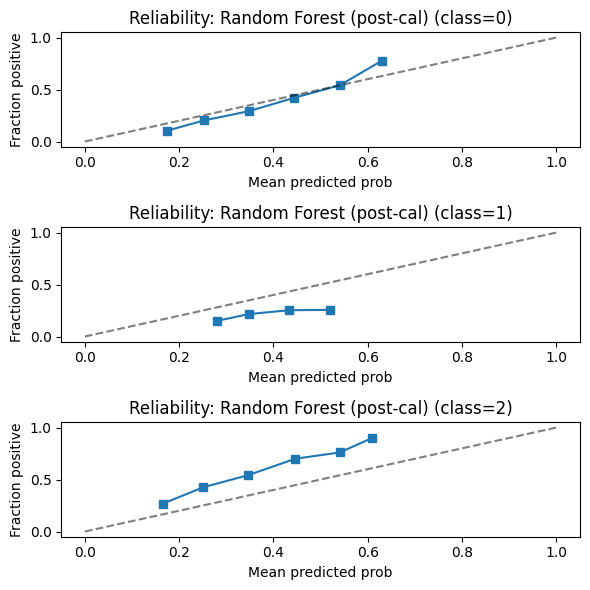


---
HistGB (post-cal):
  Log-loss: 1.0535   Multiclass Brier: 0.6329


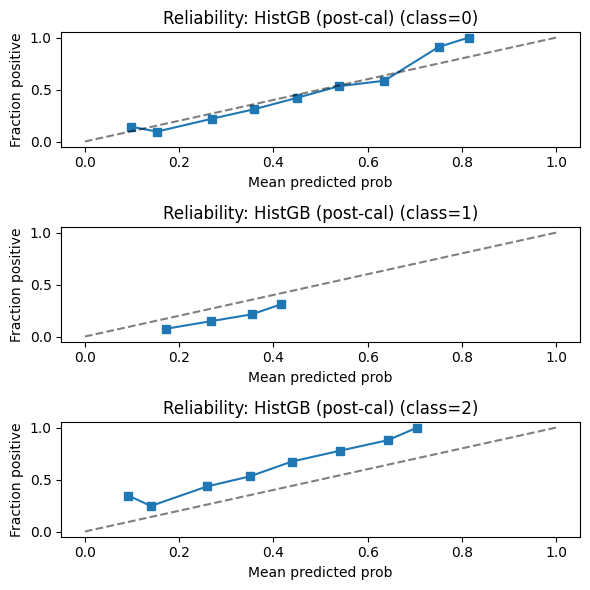

In [30]:
# Calibration diagnostics: log-loss, multiclass Brier, and reliability plots
from sklearn.metrics import log_loss
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

print('Calibration diagnostics (evaluated on X_test / y_test where available):')
for name, clf in [('Random Forest (post-cal)', rf_clf), ('HistGB (post-cal)', gb_clf)]:
    print('\n---')
    print(f'{name}:')
    if clf is None:
        print('  MISSING')
        continue
    if 'X_test' not in globals() or 'y_test' not in globals():
        print('  X_test / y_test not available — skipping diagnostics')
        continue
    try:
        probs = clf.predict_proba(X_test)
        ll = log_loss(y_test, probs)
        lb = LabelBinarizer()
        lb.fit(clf.classes_)
        yb = lb.transform(y_test)
        if yb.shape[1] != probs.shape[1]:
            print('  Warning: class ordering mismatch — cannot compute multiclass Brier/reliability plots')
            continue
        brier = np.mean(np.sum((yb - probs) ** 2, axis=1))
        print(f'  Log-loss: {ll:.4f}   Multiclass Brier: {brier:.4f}')

        # Reliability plots for up to 6 classes (keeps figure readable)
        classes = clf.classes_
        n_plot = min(len(classes), 6)
        fig, axes = plt.subplots(n_plot, 1, figsize=(6, 2 * n_plot))
        if n_plot == 1:
            axes = [axes]
        for i, cls in enumerate(classes[:n_plot]):
            prob_pos = probs[:, i]
            y_true = (y_test == cls).astype(int)
            frac_pos, mean_pred = calibration_curve(y_true, prob_pos, n_bins=10)
            axes[i].plot(mean_pred, frac_pos, marker='s')
            axes[i].plot([0, 1], [0, 1], 'k--', alpha=0.5)
            axes[i].set_title(f'Reliability: {name} (class={cls})')
            axes[i].set_xlabel('Mean predicted prob')
            axes[i].set_ylabel('Fraction positive')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print('  Diagnostics failed ->', e)

In [31]:
# Increase randomized search iterations for better coverage and rerun quick randomized search
FAST_MODE = True
n_iter_search = 100
verbose_level = 1
print(f"FAST_MODE={FAST_MODE}, n_iter_search={n_iter_search} — running randomized search with 100 iterations...")

FAST_MODE=True, n_iter_search=100 — running randomized search with 100 iterations...
